## Multiclass classification model using a custom convolutional model to detect Melanoma

### Objective

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## 1. Dataset Overview
The dataset consists of 2357 images of malignant and benign oncological diseases,contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [45]:
### importing Libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.preprocessing.image import load_img

In [25]:
# Defining the path for train and test images
# Paths of train and test dataset on local drive

data_dir_train = pathlib.Path(r"C:\Users\Hshig\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r"C:\Users\Hshig\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

## Paths of train and test dataset on local machine
# data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
# data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [35]:
# Number of images in the training directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))

# Printing the count of images in the training directory
print("Number of images in the training directory:", image_count_train)

# Counting the number of images in the test directory
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))

# Printing the count of images in the test directory
print("Number of images in the test directory:", image_count_test)

Number of images in the training directory: 2239
Number of images in the test directory: 118


Defining some parameters for the loader:

In [38]:
batch_size = 32
img_height = 180
img_width = 180

In [40]:
## Writing train dataset here

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [55]:
## Writing validation dataset here
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Found 6739 files belonging to 9 classes.


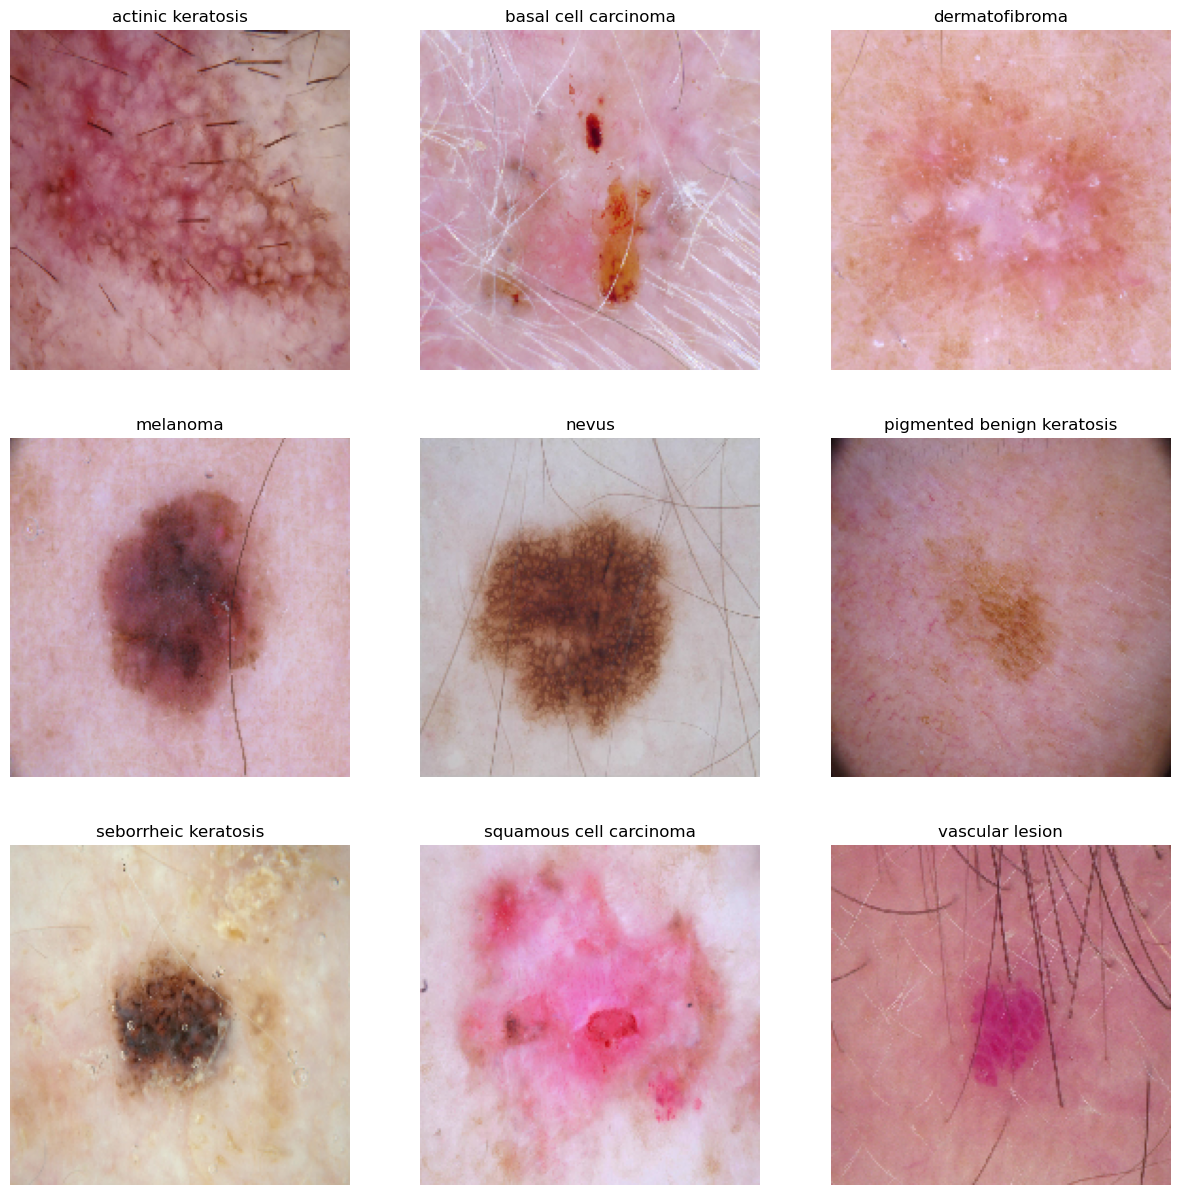

In [59]:
# Visualizing One Instance from Each Class in the Dataset

# Using image_dataset_from_directory() to create a dataset that yields batches of labeled images
# label_mode is set to 'categorical' for one-hot encoding of class labels
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180, 180), label_mode='categorical', seed=123
)

# Get the names of all the classes (skin cancer types)
class_names = image_dataset.class_names

# Dictionary to store image paths for each class
files_path_dict = {}

# Loop through each class to gather image paths
for c in class_names:
    files_path_dict[c] = list(map(lambda x: str(data_dir_train) + '/' + c + '/' + x, os.listdir(str(data_dir_train) + '/' + c)))

# Visualize an image from each class
plt.figure(figsize=(15, 15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3, 3, index)

    # Load and display the image
    plt.imshow(load_img(path_list[0], target_size=(180, 180)))
    plt.title(c)
    plt.axis("off")

In [62]:
# Defining a function to count and analyze the distribution of images in each class

def class_distribution_count(directory):
    # Initializing a list to store image counts for each class
    count = []

    # Counting the number of images in each class directory
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))

    # Getting the names of the classes (sub-directories)
    sub_directory = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

    # Creating a DataFrame with class names and corresponding image counts
    df = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Images'])

    # Sorting the DataFrame in ascending order of image counts
    df = df.sort_values(by='No. of Images', ascending=True)

    # Returning the sorted DataFrame
    return df

# Calling the function to get the class distribution and image count
class_distribution_df = class_distribution_count(data_dir_train)

# Displaying the DataFrame
class_distribution_df

,Class,No. of Images
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


In [64]:
### Creating the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [66]:
# Number of target labels are 9
target_labels = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
   layers.Dense(target_labels)
])

C:\Users\Hshig\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [75]:
### chose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [77]:
# Viewing the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 68s 307ms/step - accuracy: 0.2500 - loss: 1.9636 - val_accuracy: 0.4647 - val_loss: 1.4086
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 295ms/step - accuracy: 0.4678 - loss: 1.4350 - val_accuracy: 0.5293 - val_loss: 1.2215
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.5325 - loss: 1.2347 - val_accuracy: 0.6021 - val_loss: 1.0711
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 285ms/step - accuracy: 0.6206 - loss: 1.0392 - val_accuracy: 0.6347 - val_loss: 0.9849
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 291ms/step - accuracy: 0.6941 - loss: 0.8435 - val_accuracy: 0.6689 - val_loss: 0.9538
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 287ms/step - accuracy: 0.7508 - loss: 0.6869 - val_accuracy: 0.7082 - val_loss: 0.8367
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 286ms/step - accuracy: 0.8145 - loss: 0.5077 - val_accuracy: 0.7446 - val_loss: 0.8306
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 286ms/step - accuracy: 0.8457 - loss: 0

### Visualizing training results

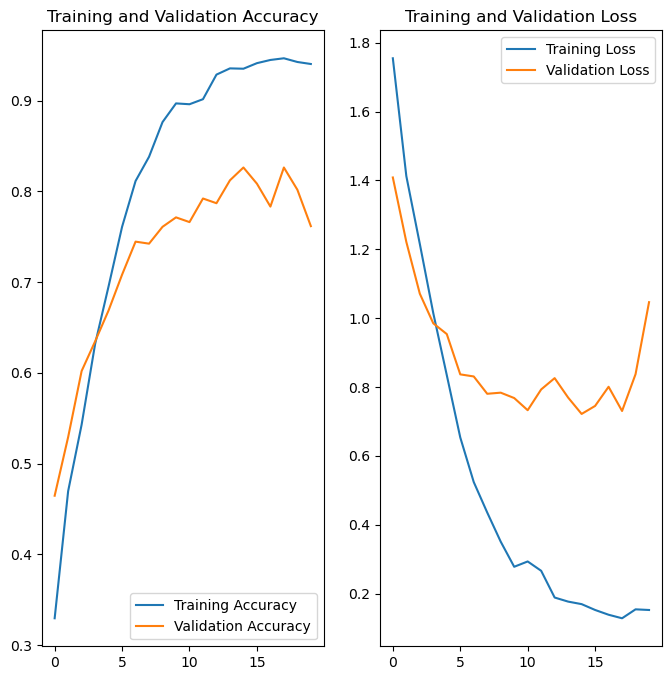

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***

1. The model's training accuracy shows a steady increase of more than 90%, while validation accuracy remains consistently around 75%.

2. A high training accuracy indicates that the data's noise has been well captured by the model. Its weak performance on validation data, however, suggests that it lacks generalisability.

3. The existence of overfitting is confirmed by these findings. Augmentation techniques will be used to solve this problem. Due to the restricted amount of training data available, the model will be trained using new samples created by making little changes to the existing data (e.g., flipping images horizontally or vertically, rotating images slightly, etc.).

In [85]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

C:\Users\Hshig\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


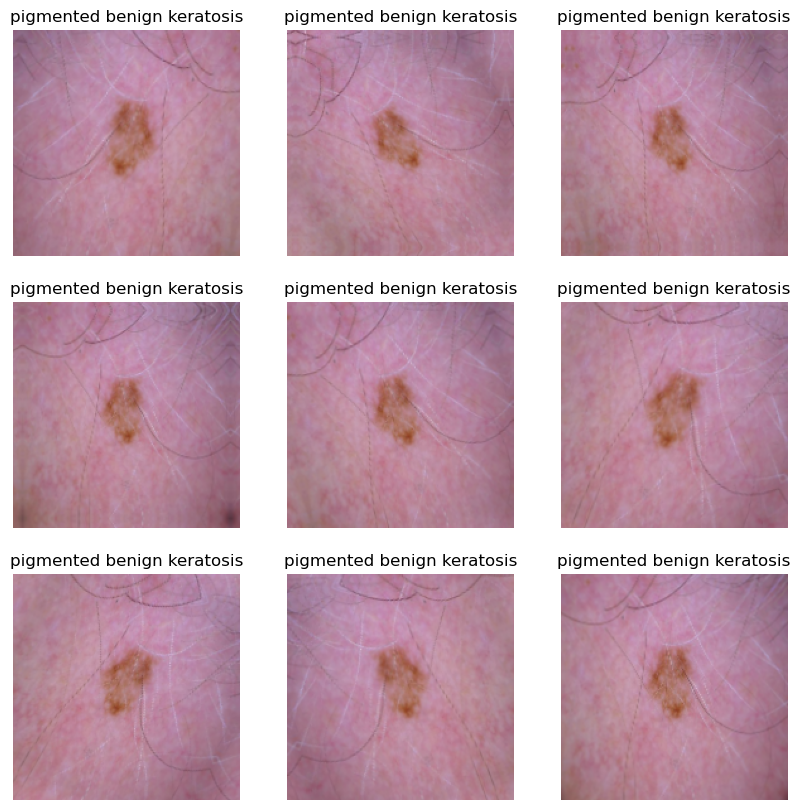

In [87]:
# Visualizing how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Creating the model, compile and train the model

In [95]:
## Using Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### Compiling the model

In [98]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [101]:
%%time
## Training model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 351ms/step - accuracy: 0.1804 - loss: 2.2025 - val_accuracy: 0.3259 - val_loss: 1.7151
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 348ms/step - accuracy: 0.3745 - loss: 1.5981 - val_accuracy: 0.4692 - val_loss: 1.4195
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 352ms/step - accuracy: 0.4540 - loss: 1.4190 - val_accuracy: 0.5100 - val_loss: 1.3649
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 344ms/step - accuracy: 0.4953 - loss: 1.3201 - val_accuracy: 0.5189 - val_loss: 1.2794
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 331ms/step - accuracy: 0.5140 - loss: 1.2810 - val_accuracy: 0.5620 - val_loss: 1.1772
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 297ms/step - accuracy: 0.5199 - loss: 1.2331 - val_accuracy: 0.5234 - val_loss: 1.2490
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 278ms/step - accuracy: 0.5529 - loss: 1.1660 - val_accuracy: 0.5664 - val_loss: 1.1493
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 269ms/step - accuracy: 0.5664 - loss: 1

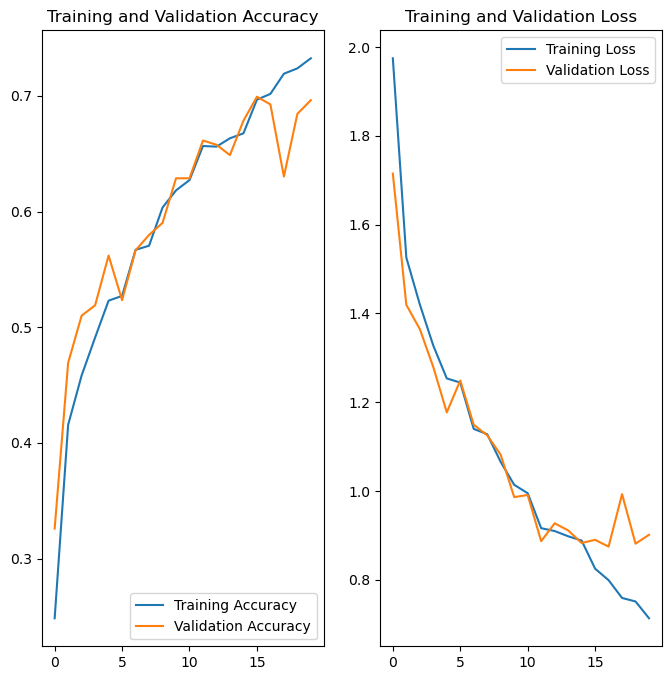

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit:

***Observations:***

1. By leveraging augmented data, overfitting has been effectively addressed.

2. The training and validation accuracy of the aforementioned model fall within a similar range.

3. Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.

#### Finding th distribution of classes in the training dataset to check Class imbalance


In [108]:

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [110]:
# Extracting image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('C:\\Users\\Hshig\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('C:\\Users\\Hshig\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis'), ('C:\\Users\\Hshig\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025825.jpg', 'actinic keratosis'), ('C:\\Users\\Hshig\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025953.jpg', 'actinic keratosis'), ('C:\\Users\\Hshig\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025957.jpg', 'actinic keratosis')]


In [112]:
# Viewing the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,C:\Users\Hshig\Downloads\CNN_assignment\Skin c...,actinic keratosis
1,C:\Users\Hshig\Downloads\CNN_assignment\Skin c...,actinic keratosis
2,C:\Users\Hshig\Downloads\CNN_assignment\Skin c...,actinic keratosis
3,C:\Users\Hshig\Downloads\CNN_assignment\Skin c...,actinic keratosis
4,C:\Users\Hshig\Downloads\CNN_assignment\Skin c...,actinic keratosis


In [114]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

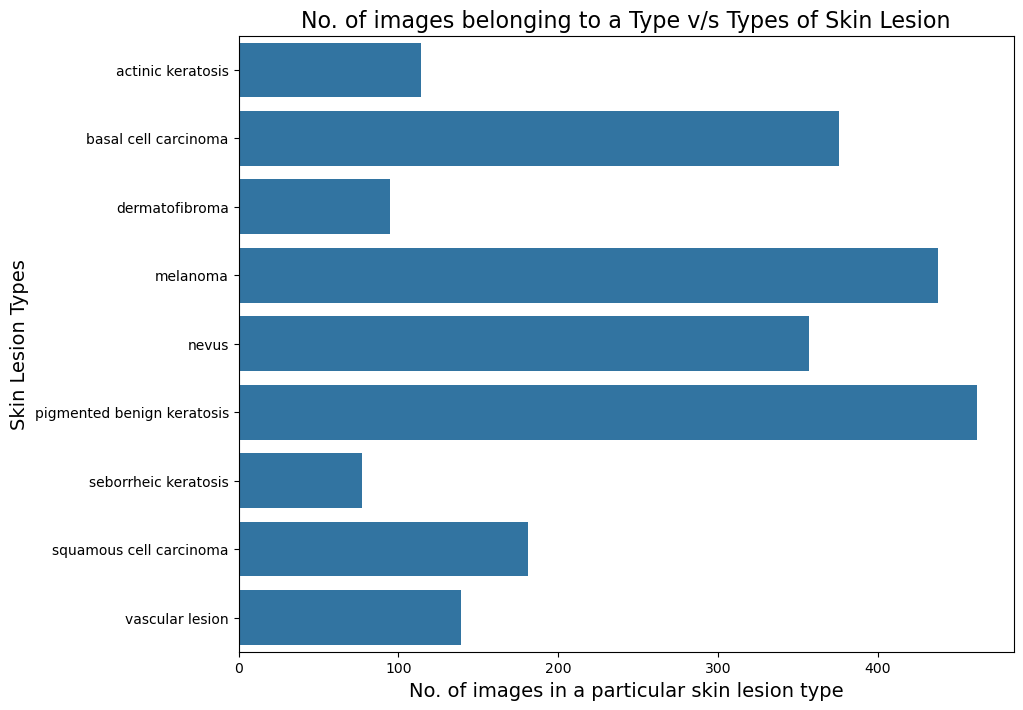

In [116]:
# Visualizing the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [118]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64

***Observations:***

1. A clear class imbalance is evident within the training data.

2. The class **"seborrheic keratosis"** comprises the smallest proportion of samples, accounting for approximately **3.44%**.

3. **"Pigmented benign keratosis"** and **"melanoma"** significantly outweigh other classes, representing approximately **20.63%** and **19.56%** of the data, respectively.

#### Rectifying the class imbalance using Augmentor


In [123]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\Hshig\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE07FF3D10>: 100%|██████████| 500/500 [00:04<00:00, 123.80 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to C:\Users\Hshig\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE07F68F80>: 100%|██████████| 500/500 [00:04<00:00, 122.28 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Users\Hshig\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE07F14B60>: 100%|██████████| 500/500 [00:04<00:00, 124.02 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to C:\Users\Hshig\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CE07FC6F00>: 100%|██████████| 500/500 [00:23<00:00, 21.48 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to C:\Users\Hshig\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x1CE080401A0>: 100%|██████████| 500/500 [00:17<00:00, 28.90 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:\Users\Hshig\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE07F640E0>: 100%|██████████| 500/500 [00:03<00:00, 135.53 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to C:\Users\Hshig\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CE08009520>: 100%|██████████| 500/500 [00:08<00:00, 60.87 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\Hshig\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE080BA3F0>: 100%|██████████| 500/500 [00:03<00:00, 141.92 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Users\Hshig\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE07F4BF50>: 100%|██████████| 500/500 [00:03<00:00, 133.69 Samples/s]                  


In [125]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

In [132]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['C:\\Users\\Hshig\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_5fbeef04-0649-4d5e-84bf-83d404a19746.jpg',
 'C:\\Users\\Hshig\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_97c6d7ce-9317-4481-958a-19da769c1949.jpg',
 'C:\\Users\\Hshig\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b234d5b5-9698-4c19-86d1-33beb6b471b1.jpg',
 'C:\\Users\\Hshig\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b7731cc2-247d-4a25-9665-87a4addfd478.jpg',
 'C:\\Users\\Hshig\\Downloads\\CNN_assignment\\Skin cancer ISIC The Internat

In [136]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [140]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [142]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
#new_df = lesions_df.append(df2)
new_df.shape

(11239, 2)

In [144]:
# Viewing the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,C:\Users\Hshig\Downloads\CNN_assignment\Skin c...,actinic keratosis
1,C:\Users\Hshig\Downloads\CNN_assignment\Skin c...,actinic keratosis
2,C:\Users\Hshig\Downloads\CNN_assignment\Skin c...,actinic keratosis
3,C:\Users\Hshig\Downloads\CNN_assignment\Skin c...,actinic keratosis
4,C:\Users\Hshig\Downloads\CNN_assignment\Skin c...,actinic keratosis


In [146]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()


Label
pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: count, dtype: int64

In [148]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

Label
pigmented benign keratosis    13.01
melanoma                      12.79
basal cell carcinoma          12.24
nevus                         12.07
squamous cell carcinoma       10.51
vascular lesion               10.13
actinic keratosis              9.91
dermatofibroma                 9.74
seborrheic keratosis           9.58
Name: proportion, dtype: float64

#### Training the model on the data created using Augmentor

In [64]:
batch_size = 32
img_height = 180
img_width = 180

Initial Model Train Accuracy: 0.9090909090909091
Initial Model Test Accuracy: 0.9016919163994249
CPU times: user 5min 10s, sys: 515 ms, total: 5min 10s
Wall time: 5min 15s


#### Creating a training dataset

In [154]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### Creating your model (make sure to include normalization)

In [157]:

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compiling model (Choose optimizer and loss function appropriately)

In [160]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Training your model

In [163]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 168s 568ms/step - accuracy: 0.2654 - loss: 3.1768 - val_accuracy: 0.1084 - val_loss: 20.4352
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 164s 583ms/step - accuracy: 0.4485 - loss: 1.4543 - val_accuracy: 0.4670 - val_loss: 1.4233
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 160s 570ms/step - accuracy: 0.4855 - loss: 1.3051 - val_accuracy: 0.4967 - val_loss: 1.3570
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 158s 561ms/step - accuracy: 0.5087 - loss: 1.2502 - val_accuracy: 0.5137 - val_loss: 1.2277
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 157s 559ms/step - accuracy: 0.5454 - loss: 1.1620 - val_accuracy: 0.5865 - val_loss: 1.0771
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 154s 546ms/step - accuracy: 0.5767 - loss: 1.1232 - val_accuracy: 0.6221 - val_loss: 1.0022
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 145s 514ms/step - accuracy: 0.5999 - loss: 1.0548 - val_accuracy: 0.6459 - val_loss: 0.9261
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 145s 515ms/step - accuracy: 0.6166 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***

1. Implementing batch normalization in the model yielded a slight uptick in both training and validation accuracy.
2. Formulating an alternative model without batch normalization aims to investigate prospective improvements in accuracy.

#### Creating another model (without batch normalization)

In [167]:
# create the model
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compiling the model

In [170]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

#### Training the model

In [173]:
%%time
# train the model
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.3064 - loss: 1.7977
Epoch 1: val_accuracy improved from -inf to 0.48478, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 57s 198ms/step - accuracy: 0.3067 - loss: 1.7969 - val_accuracy: 0.4848 - val_loss: 1.4014
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.4660 - loss: 1.3730
Epoch 2: val_accuracy improved from 0.48478 to 0.55679, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 58s 205ms/step - accuracy: 0.4661 - loss: 1.3728 - val_accuracy: 0.5568 - val_loss: 1.1794
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5274 - loss: 1.2265
Epoch 3: val_accuracy improved from 0.55679 to 0.57684, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 65s 230ms/step - accuracy: 0.5275 - loss: 1.2264 - val_accuracy: 0.5768 - val_loss: 1.0950
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5624 - loss: 1.1444
Epoch 4: val_accuracy improved from 0.5

#### Visualize the model results

In [176]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

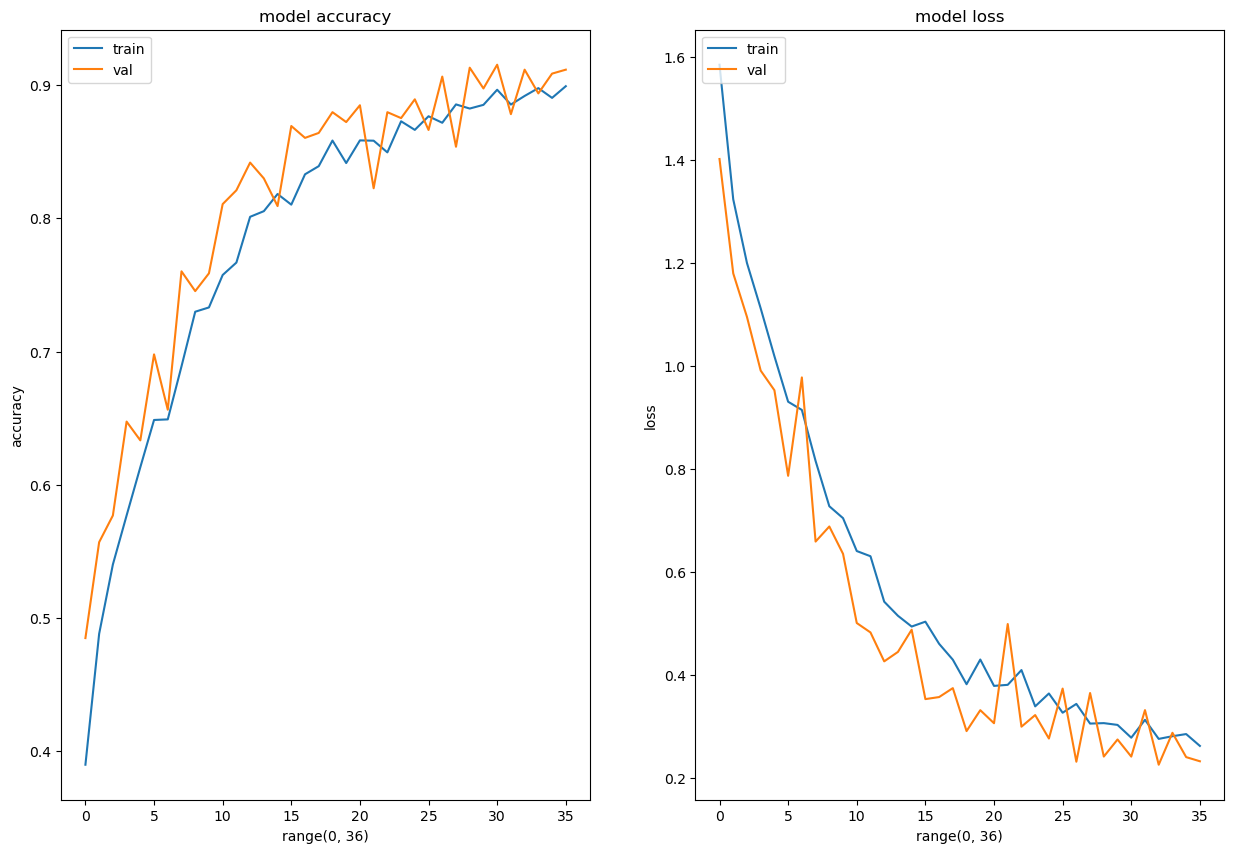

In [178]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

In [187]:
###Observations:

#1. The ultimate model showcases well-balanced performance, displaying no signs of underfitting or overfitting.

#2. The implementation of class rebalancing has notably enhanced the models performance across both training and validation datasets.

#3. Following 36 epochs, the final model attains an accuracy of 84% on the training set and approximately 79% on the validation set.

#4. The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

#5. The addition of batch normalization failed to enhance both training and validation accuracy.

### Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Actual Class: nevus
Predicted Class: nevus


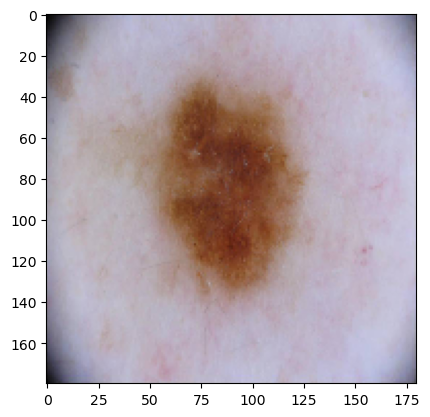

In [202]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[4], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-4], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[4] +'\n'+ "Predicted Class: " + predicted_class)